# Human Activity Recognition using PyTorch

This is an exercise to implement a few deep learning models for recognising human activities (like walking, standing, etc) from sensor data (accelerometer and gyroscope) collected from mobile phones.

We use Jason Brownlee's tutorial (https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/) as a source of inspiration and look to implement the models in PyTorch.


## The Dataset

As the tutorial suggests, we are going to use the same dataset - [Human Activity Recognition Using Smartphones Data Set, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)


The dataset contains sensor data recorded for the following activities:

    Walking
    Walking Upstairs
    Walking Downstairs
    Sitting
    Standing
    Laying

The sensor data is made up of accelerometer data (x,y and z) and gyroscope data (angular velocity), with observations recorded at 50Hz.

Please refer to Jason's article above for a detailed description of the dataset, but in summary, the data is already pre-processes and split into windows of 128 data points (2.56 seconds) with a 50% overlap between adjacent rows.

The dataset contains a bunch of engineered features, but for this exercise we will only use three sets of raw features:
    body acceleration (x,y,z)
    body gyroscope (x,y,z)
    total acceleration(x,y,z)
    
That is, 9 features for every observation of 128 data points.

The first step is to load the data and see what it looks like

In [1]:
# All the imports in one place
import os
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import Conv1d, Conv2d, Sequential, ModuleList, BatchNorm2d
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchvision import transforms

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import matplotlib.pyplot as plt


### DataLoader

We need a data loader to extract data from the txt files and format it for us

In [2]:
class HARDataLoader:
    def __init__(self, data_root):
        self.data_root = data_root
        
    def pre_operation(self, **kwargs):
        pass
    
    def post_operation(self, **kwargs):
        X = kwargs.get("X", None)
        y = kwargs.get("y", None)
        return X, y
       

    # load a single file as a numpy array
    def load_file(self, filepath):
        dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
        return dataframe.values

    # load a list of files into a 3D array of [samples, features, timesteps]
    def load_group(self, filenames, prefix=''):
        loaded = list()
        for name in filenames:
            data = self.load_file(prefix + name)
            loaded.append(data)
        
        # stack group and transpose to (samples, features, timesteps)
        loaded = np.dstack(loaded).transpose(0,2,1)
        return loaded

    # load a dataset group, such as train or test
    def load_dataset_group(self, group):
        filepath = os.path.join(self.data_root, group, 'Inertial Signals/')
        # load all 9 files as a single array
        filenames = list()
        # total acceleration
        filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
        # body acceleration
        filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
        # body gyroscope
        filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
        # load input data
        X = self.load_group(filenames, filepath)
        # load class output
        y = self.load_file(os.path.join(self.data_root, group, 'y_'+group+'.txt'))
        return X, y

    # load the dataset, returns train and test X and y elements
    def load_dataset(self, **kwargs):
        
        train_test = kwargs.get("train_test", "train")
        
        self.pre_operation(**kwargs)
        
        # load all train
        X, y = self.load_dataset_group(train_test)
        
        # zero-offset class values
        y = y - 1
        
        X, y = self.post_operation(X=X, y=y)
        
        return X, y
    
    def load_labels(self):
        labels_file = os.path.join(self.data_root, 'activity_labels.txt')
        return list(pd.read_csv(labels_file, header=None, delim_whitespace=True)[1].array)

    def to_categorical(self, y, num_classes):
        """ 1-hot encodes a tensor """
        return np.eye(num_classes, dtype='uint8')[y]
    
    # standardize data
    def scale_data(self, trainX, testX, standardize):
        # remove overlap
        cut = int(trainX.shape[1] / 2)
        longX = trainX[:, -cut:, :]
        # flatten windows
        longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
        # flatten train and test
        flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
        flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
        # standardize
        if standardize:
            s = StandardScaler()
            # fit on training data
            s.fit(longX)
            # apply to training and test data
            longX = s.transform(longX)
            flatTrainX = s.transform(flatTrainX)
            flatTestX = s.transform(flatTestX)
        # reshape
        flatTrainX = flatTrainX.reshape((trainX.shape))
        flatTestX = flatTestX.reshape((testX.shape))
        return flatTrainX, flatTestX

### Test the HARDataLoader

In [3]:
dl = HARDataLoader('./UCI_HAR_Dataset')

# Load the dataset
train_X, train_y = dl.load_dataset(train_test='train') 
test_X, test_y = dl.load_dataset(train_test='test')


print("Training Data:", train_X.shape, train_y.shape)
print("Testing Data:", test_X.shape, test_y.shape)

Training Data: (7352, 9, 128) (7352, 1)
Testing Data: (2947, 9, 128) (2947, 1)


## Custom Dataset for torch DataLoader
We need a custom data loader class to convert the above 
trainX, trainY and testX, testY arrays into a torch DataSet.
This is to make use of torch.DataLoader for easy loading of data in batches for training.

In [4]:
class HARDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.Transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.y[index]
        if self.Transform:
            return self.Transform(x), y
        else:
            return x, y

    def __len__(self):
        return len(self.X)

### Test the HARDataset

In [5]:
# Create torch datasets and data loaders for train and test
train_set = HARDataset(train_X, train_y)
test_set = HARDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

print("Num Training samples: ", len(train_loader.dataset))
print("Num Testing samples:", len(test_loader.dataset))


Num Training samples:  7352
Num Testing samples: 2947


# Training and evaluating the model

We are going to evaluate various models with various hyper-parameters.
For this, let's define a framework to make it easy for us to iterate.

Below, we define classes called `Experiment` and `ComparativeExperiment` and we create objects of these classes to run our experiments.

A simple example is

```
# define a config dictionary object with all the parameters
config = dict(
    # ---- network parameters
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    
    # ---- training parameters
    repeats = 10,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    verbose = False
)

# create the experiment object
experiment1 = Experiment(config)

# run the experiment.
experiment1.run()

```

Once a Model class is defined (as shown after the next two cells), you can run different variations of experiments by changing the parameters in the config.


In [19]:
class Experiment:
    def __init__(self, config):
        self.config = config
        self.best_predictions = torch.empty(0)
        self.actuals = torch.empty(0)
        self.best_score = 0.0
        self.best_model = None
        self.labels=[]
        self.verbose = config.get("verbose", False)
        
        
    '''
        Function to update the config.
        Should be called by the experimenter is config needs to be 
        updated between experiment runs.
    '''
    def update_config(self, config):
        self.config = config
    
    '''
        Trains the network for n epochs and returns an accuracy score
    '''
    def train_and_evaluate(self, train_loader, test_loader):
        
        # If a random seed is set, weights, etc are initialised consistently 
        # between different runs.
        random_seed = self.config.get("random_seed", 0)
        if random_seed > 0:
            torch.manual_seed(random_seed)
        
        net_class = self.config.get("net_class", None)
        
        # We need the class name of the network to create dynamically.
        if net_class is None:
            print("net_class not supplied.")
            return
        
        # Create the net object from the class name. 
        net = globals()[net_class](self.config)
        
        if self.config.get("init_weights", False):
            # Initialise the network's weights
            net.apply(self.init_weights)
        
        # Get all the config parameters
        lr = self.config.get("lr", 0.01)
        batch_size = self.config.get("batch_size", 32)
        epochs = self.config.get("epochs_per_repeat",10)
        
        # Create the optimiser
        optimiser = optim.Adam(net.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        train_size = len(train_loader.dataset)
        for epoch in range(epochs):
            
            # Training
            
            net.train()
            correct = 0
            for X, y in train_loader:
                optimiser.zero_grad()
                X, y = X.float(), y.long().squeeze()
                
                out = net(X)
                if len(out) == 2:
                    y_hat, logits = out
                else:
                    y_hat, logits = out, out
                    
                loss = loss_fn(logits, y)
                loss.backward()
                optimiser.step()
                predicted = torch.argmax(y_hat.data,1)
                correct += (predicted == y).sum()

            acc_train = float(correct) * 100.0 / train_size
            if self.verbose:
                print("Train accuracy:", acc_train, "Loss: ", loss.item())
            
            # Interim Evaluation
            if epoch % 10 == 0:
                if self.verbose:
                    accuracy, actuals, predictions = self.evaluate(net, test_loader)
                    print("Testing accuracy: ", accuracy)
                
        # Final Evaluation
        accuracy, actuals, predictions = self.evaluate(net, test_loader)
        if accuracy > self.best_score:
            self.best_score = accuracy
            self.best_predictions = predictions
            self.best_model = net
            self.actuals = actuals
        return accuracy.item()

    
    def evaluate(self, net, test_loader):
        net.train(False)
        predictions = torch.empty(0)
        actuals = torch.empty(0)
        total_test_size = 0
        with torch.no_grad():
            correct = 0
            for X, y in test_loader:
                X, y = X.float(), y.long().squeeze()

                out = net(X)
                if len(out) == 2:
                    y_hat, logits = out
                else:
                    y_hat, logits = out, out

                predicted = torch.argmax(y_hat.data,1)
                predictions = torch.cat((predictions.float(), predicted.float()),0) 
                actuals = torch.cat((actuals.float(), y.float()), 0)
                total_test_size += y.size(0)
                correct += (predicted.numpy() == y.numpy()).sum()
        accuracy = correct * 100. / total_test_size
        return accuracy, actuals, predictions

    
    def init_weights(self, m):
        if type(m) in (nn.Linear, nn.Conv1d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
    
    '''
        summarize scores
    '''
    def summarize_results(self):
        m, s = np.mean(self.scores), np.std(self.scores)
        repeats = self.config.get("repeats", 10)
        print('Accuracy over {0} trials: {1:.3f}% (+/-{2:.3f})'.format(repeats, m, s))
        
        print('Best model accuracy: {0:.3f}%'.format(np.max(self.scores)))
        
        # confusion matrix for best scores
        conf_matrix = confusion_matrix(self.actuals, self.best_predictions)
        df_cm = pd.DataFrame(conf_matrix, index = self.labels, columns = self.labels)
        plt.figure(figsize = (3,3))
        plt.title('Confusion Matrix For Best Run', fontsize=20)
        sns.heatmap(df_cm, annot=True, fmt='g')
        plt.show()
        if len(self.scores) > 1:
            self._plot(self.scores)

    # helper function to plot scores
    def _plot(self, data):
        plt.figure(figsize = (3,3))
        sns.lineplot(range(1, len(data) + 1), data)
        
        plt.xlabel('Repeats', fontsize=14)
        plt.ylabel('Accuracy(%)', fontsize=14)
        plt.title('Test Accuracy', fontsize=20)
        plt.show()

    ''' 
        Run the experiment
    '''
    def run(self):
        
        # load data
        har_dataloader = HARDataLoader('./UCI_HAR_Dataset')
        train_X, train_y = har_dataloader.load_dataset(train_test='train') 
        test_X, test_y = har_dataloader.load_dataset(train_test='test')
        self.labels = har_dataloader.load_labels()
        
        # scale data
        if self.config.get("standardize", False):
            train_X, test_X = har_dataloader.scale_data(train_X, test_X, standardize=True)

        # repeat experiment
        self.scores = list()
        repeats = self.config.get("repeats", 10)
        batch_size = self.config.get("batch_size", 32)
        for r in range(repeats):
            # Create the data loaders
            train_set = HARDataset(train_X, train_y)
            test_set = HARDataset(test_X, test_y)
            train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

            # train and evaluate the model
            score = self.train_and_evaluate(train_loader, test_loader)
            print('#{0}: {1:.3f}'.format(r+1, score))
            self.scores.append(score)
        # summarize results
        self.summarize_results()

#### Compatative Experiments
Use this to perform comparative experiments where
    you want to try different values or one of the 
    (hyper)parameters.
    
Note: To keep weights initialised to the same values,
torch.manual_seed() is used to set the random seed.
This makes sure results between runs of experiments 
are comparable.

Use "repeat_on" parameter of the config to specify which parameter 
you want to repeat the experiments on.
Then use the parameter setting as an array of values.
        
Eg:
    
    config = dict(
        # ---- network parameters
        net_class = "CNN_1D_Model",
        n_filters = 64,
        kernel_size = 3,
        dropout = 0.5,

        # ---- training parameters
        epochs_per_repeat = 10,
        lr = 0.001,
        repeat_on = "batch_size", # Which parameter do we want to repeat the experiment on
        batch_size = [8,16,32,64,128,256] # list of different values for the parameter
        
    )
    comparative_experiment = ComparativeExperiment(config)
    comparative_experiment.run()
    

In [7]:
class ComparativeExperiment():

    def __init__(self, config):
        self.config = config
        
    ''' 
        Run the experiment
    '''
    def run(self):
        
        # which parameter are we repeating experiments on?
        repeat_on = self.config.get("repeat_on", "")
        print("Experiments on changing {}".format(repeat_on))
        if repeat_on != "":
            repeats = self.config.get(repeat_on, [])
            config = copy.copy(self.config)
            for repeat in repeats:
                print("Starting experiment with {0}={1}".format(repeat_on, repeat))
                config[repeat_on] = repeat
                config["repeats"] = 1
                config["random_seed"] = 28
                experiment = Experiment(config)
                experiment.run()


# CNN Model 1

Let's define the first CNN model with 1D conv layers as used in the article.
The network architecture is:

`Conv1D -> Conv1D -> Dropout -> MaxPool -> FullyConnected -> FullyConnected -> Softmax`

In [8]:
class CNN_1D_Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        n_filters = self.config.get("n_filters", 64)
        kernel_size = self.config.get("kernel_size", 3)
        dropout = self.config.get("dropout", 0.5)
        
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=n_filters, kernel_size=kernel_size, stride=1)
        self.conv2 = nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size, stride=1)
        self.dropout1 = nn.Dropout(p=dropout)
        self.max_pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Need to do this to figure out the input size of the next Linear layer.
        # Call the _convolutions with dummy data and get the shape of the output
        x = torch.rand(1,9,128)
        x = self._convolutions(x)
        self.fc_size = x.shape[1] * x.shape[2]

        self.fc1 = nn.Linear(in_features=self.fc_size, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=6)
        
    def _convolutions(self, x):
        # expected shape of x is (1, 9, 128)
        x = self.conv1(x)
        x = F.relu(x)
        # shape of x now is (1, 64, 126)
        x = self.conv2(x)
        x = F.relu(x)
        # shape of x now is (1, 64, 124)
        
        # Dropout
        x = self.dropout1(x)
        # shape of x now is (1, 64, 124)
        
        # MaxPool
        x = self.max_pool1(x)
        # shape of x now is (1, 64, 62)
        return x
        
    def forward(self, x):
        
        x = self._convolutions(x)
        
        # Flatten
        #x = torch.flatten(x)
        x = x.view(-1, self.fc_size)
        # shape of x now is (3968)
        #print(x.shape)
        
        # Fully connected (Dense layers)
        x = self.fc1(x)
        x = F.relu(x)
        # shape of x now is (100)
        x = self.fc2(x)
        x = F.relu(x)
        # shape of x now is (6)
        
        # apply softmax
        y_hat = F.softmax(x, dim=1)
        return (y_hat, x)

### Experiment 1

Our first experiment is to re-create the first experiment from the article.
1DCNN model, trained for 10 epochs with batch size of 32. Repeating 10 times.

#1: 18.222
#2: 18.222
#3: 61.656
#4: 18.222
#5: 44.011
#6: 32.440
#7: 89.447
#8: 18.222
#9: 18.222
#10: 18.222
Accuracy over 10 trials: 33.688% (+/-23.312)
Best model accuracy: 89.447%


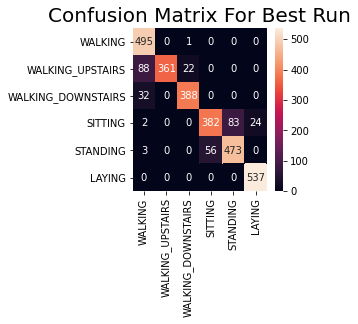

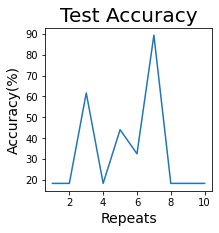

In [21]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 10,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    init_weights = True, # Initialises weights using kaiming_uniform_()
    verbose = False
)
experiment1 = Experiment(config)
experiment1.run()

### Experiment 1a
Same as experiment 1 but disabling weight initialisation.

#1: 46.658
#2: 18.222
#3: 18.222
#4: 18.222
#5: 32.440
#6: 46.386
#7: 91.992
#8: 78.012
#9: 91.822
#10: 18.222
Accuracy over 10 trials: 46.020% (+/-29.173)
Best model accuracy: 91.992%


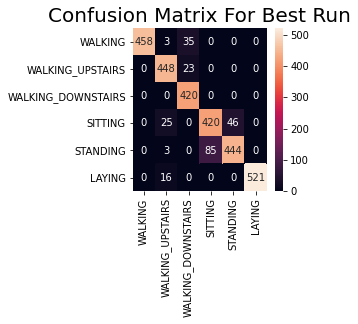

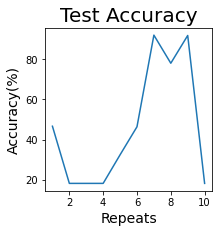

In [22]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 10,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    init_weights = False,
    verbose = False
)
experiment1a = Experiment(config)
experiment1a.run()

### Experiment 2

Trying the same 1D model but with 5 epochs per repeat to see if training longer is deteriorating the performance.

#1: 32.474
#2: 33.152
#3: 18.222
#4: 46.250
#5: 61.554
#6: 18.222
#7: 63.624
#8: 18.222
#9: 77.503
#10: 18.222
Accuracy over 10 trials: 38.744% (+/-21.102)
Best model accuracy: 77.503%


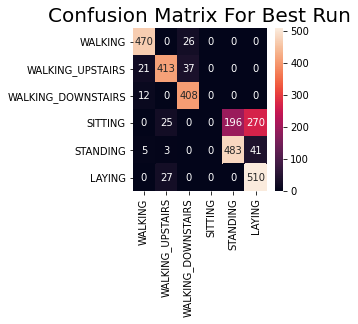

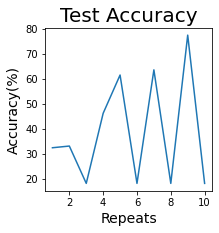

In [23]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 10,
    epochs_per_repeat = 5,
    lr = 0.001,
    batch_size = 32,
    verbose = False
)
experiment2 = Experiment(config)
experiment2.run()


So, 5 epochs is not enough to converge.

### Experiment 3

Trying the same 1D models with slower learning rate, but 50 epochs. Let's try for 1 repeat.

Train accuracy: 40.65560391730141 Loss:  1.2152276039123535
Testing accuracy:  49.6437054631829
Train accuracy: 69.61371055495103 Loss:  0.7245987057685852
Train accuracy: 77.67954298150163 Loss:  0.43020522594451904
Train accuracy: 79.31175190424375 Loss:  0.4042089283466339
Train accuracy: 79.93743199129489 Loss:  0.47787073254585266
Train accuracy: 80.2366702937976 Loss:  0.3186376392841339
Train accuracy: 80.39989118607181 Loss:  0.30843934416770935
Train accuracy: 80.39989118607181 Loss:  0.3954589366912842
Train accuracy: 80.41349292709467 Loss:  0.3814137279987335
Train accuracy: 80.30467899891185 Loss:  0.32493773102760315
Train accuracy: 80.53590859630033 Loss:  0.28067925572395325
Testing accuracy:  76.68815744825245
Train accuracy: 80.53590859630033 Loss:  0.7709236741065979
Train accuracy: 80.54951033732318 Loss:  0.16489744186401367
Train accuracy: 80.35908596300327 Loss:  0.6336129903793335
Train accuracy: 80.39989118607181 Loss:  0.2687922716140747
Train accuracy: 80.427

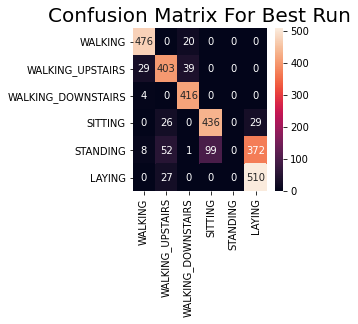

In [25]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 1,
    epochs_per_repeat = 50,
    lr = 0.0001,
    batch_size = 32,
    verbose = True
)
experiment3 = Experiment(config)
experiment3.run()

### Experiment 4

The above accuracy for 50 epochs looks good, so let's try 10 repeats.

In [ ]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 10,
    epochs_per_repeat = 50,
    lr = 0.0001,
    batch_size = 32,
    verbose = False
)
experiment4 = Experiment(config)
experiment4.run()


### Observation

As you can see from the above experiments, the accuracies are fluctuating wildly with some runs exceeding 90% accuracy. This is most likely because of the weight initialisation starting points. 

I am not sure how it worked so consistently in the article.

I would like to try the keras models from the article myself at some point.

### Experiment 5

Increased the kernel size in the conv1D layers to 5.
Trying out 10 repeats of 10 epochs

#1: 18.222
#2: 47.608
#3: 64.167
#4: 76.892
#5: 34.476
#6: 63.149
#7: 90.092
#8: 93.078
#9: 77.706
#10: 77.231
Accuracy over 10 trials: 64.262% (+/-23.003)


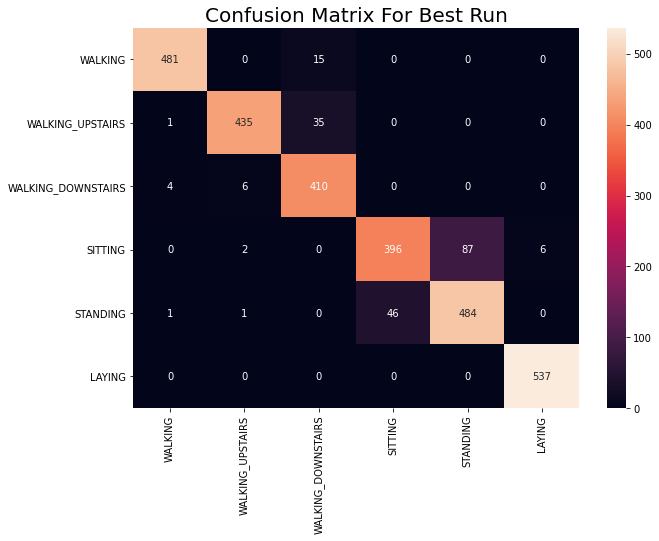

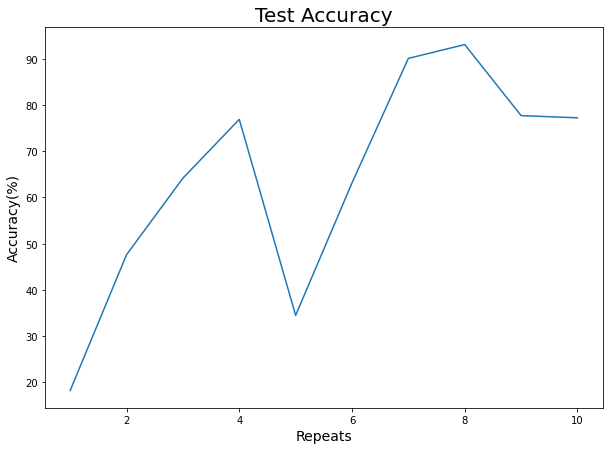

In [22]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 5,
    dropout = 0.5,
    repeats = 10,
    epochs_per_repeat = 50,
    lr = 0.001,
    batch_size = 32,
    verbose = False
)
experiment5 = Experiment(config)
experiment5.run()

# LSTM Model

I was not able to get good consistent results with the 1DCNN model, so looked at LSTM models. Inspired by a simple example I found online.

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, config):
        super(LSTMModel, self).__init__()
        
        self.config = config
        
        input_dim = self.config["input_dim"]
        output_dim = self.config["output_dim"]
        
        # Hidden dimensions
        self.hidden_dim = self.config["hidden_dim"]

        # Number of hidden layers
        self.layer_dim = self.config["layer_dim"]

        # Build the LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, self.hidden_dim, self.layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        
        # x is in shape (batch_sise, 9, 128)
        # need to transpose it to (batch_size, 128, 9)
        x = torch.transpose(x, 2, 1)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 6
        return out

### Experiment 6

1D Convolution models are not performing great, so trying a simple LSTM model to start with.
Train for 10 epochs for 1 repeat.

#1: 55.955
Accuracy over 1 trials: 55.955% (+/-0.000)


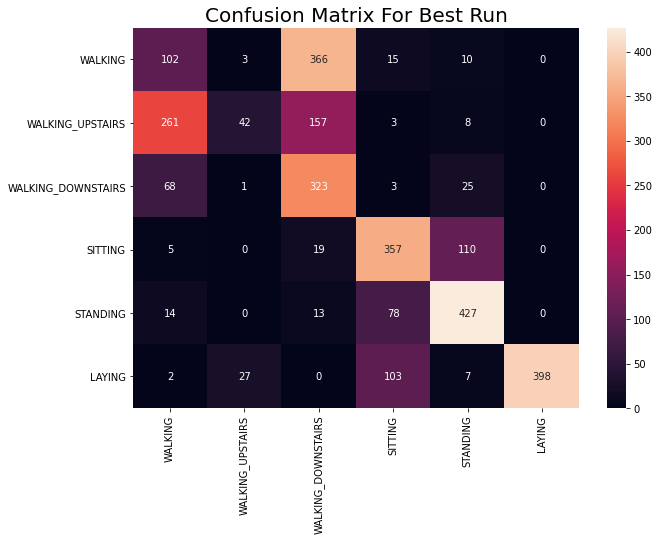

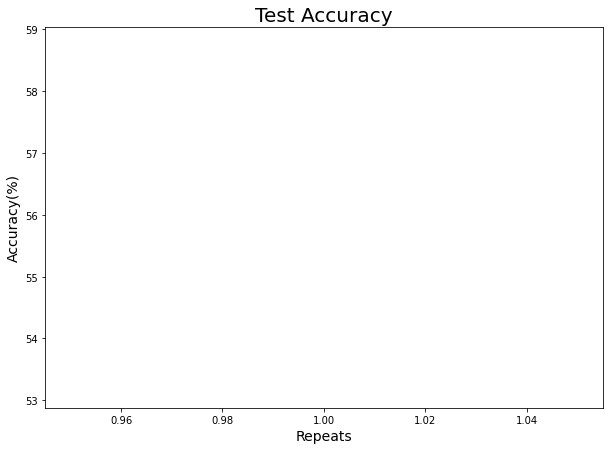

In [24]:
config = dict(
    net_class = "LSTMModel",
    # network related config
    input_dim = 9, # number of rows in the input
    hidden_dim = 100,
    layer_dim = 1,
    output_dim = 6
    #-----
    repeats = 1,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32
)
experiment6 = Experiment(config)
experiment6.run()

### Experiment 7

Trying the same LSTM model for 50 epocs

#1: 91.313
Accuracy over 1 trials: 91.313% (+/-0.000)


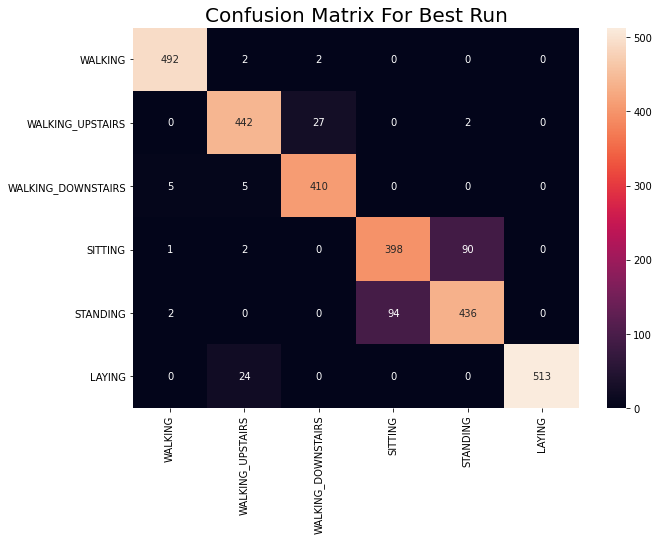

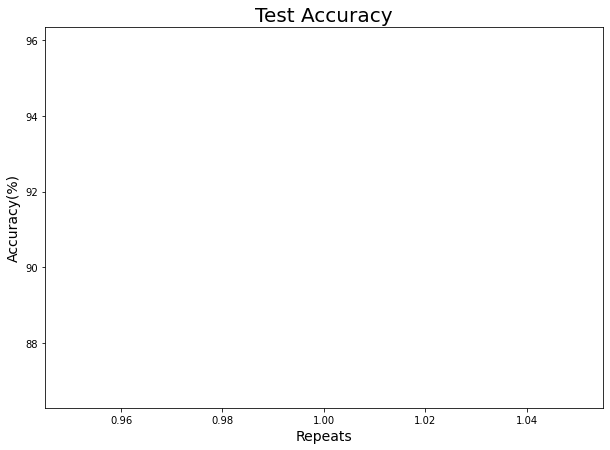

In [25]:
config = dict(
    net_class = "LSTMModel",
    # network related config
    input_dim = 9, # number of rows in the input
    hidden_dim = 100,
    layer_dim = 1,
    output_dim = 6
    #-----
    repeats = 1,
    epochs_per_repeat = 50,
    lr = 0.001,
    batch_size = 32
)
experiment7 = Experiment(config)
experiment7.run()

### Experiment 8

LSTM looks promising at 50 epocs. Lets try 10 repeats. 

NOTE: This takes a looooong time on CPU.

#1: 91.890
#2: 90.363
#3: 91.211
#4: 90.092
#5: 89.752
#6: 91.279
#7: 90.974
#8: 91.720
#9: 91.008
#10: 91.585
Accuracy over 10 trials: 90.987% (+/-0.675)


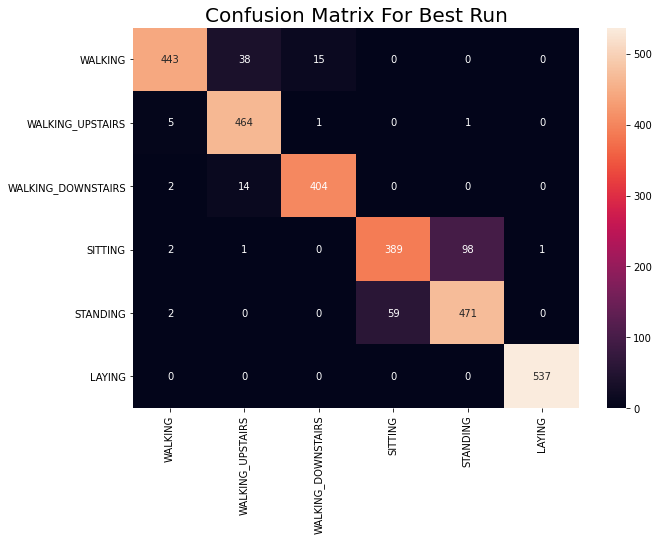

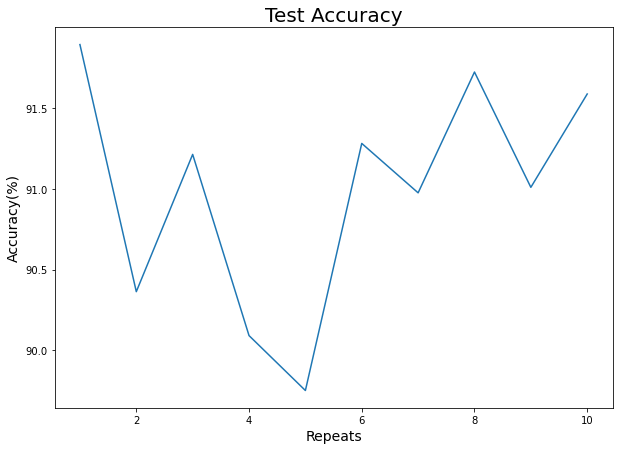

In [26]:
config = dict(
    net_class = "LSTMModel",
    # network related config
    input_dim = 9, # number of rows in the input
    hidden_dim = 100,
    layer_dim = 1,
    output_dim = 6
    #-----
    repeats = 10,
    epochs_per_repeat = 50,
    lr = 0.001,
    batch_size = 32
)
experiment8 = Experiment(config)
experiment8.run()

## LSTM is working much better than 1DConv model
Each iteration of the experiment takes about 20mins, meaning the experiment takes about 3hrs.

Given the lack of time, I am not attempting this more than once.

### Comparative Experiment 1

This is one experiment to show how a comparative experiment works. I could expand further on what hyper-parameters can be experimented with. Perhaps in the next version.

Let's try the 1DConv model with different batch sizes.

Experiments on changing batch_size
Starting experiment with batch_size=8
#1: 47.268
Accuracy over 1 trials: 47.268% (+/-0.000)


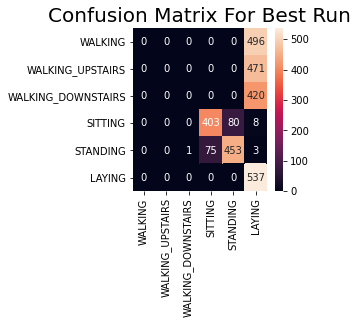

Starting experiment with batch_size=16
#1: 74.245
Accuracy over 1 trials: 74.245% (+/-0.000)


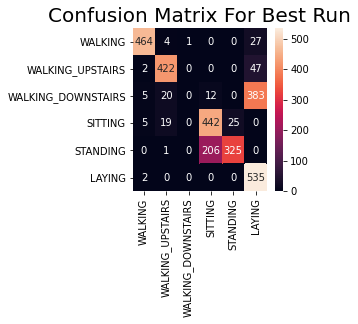

Starting experiment with batch_size=32
#1: 75.840
Accuracy over 1 trials: 75.840% (+/-0.000)


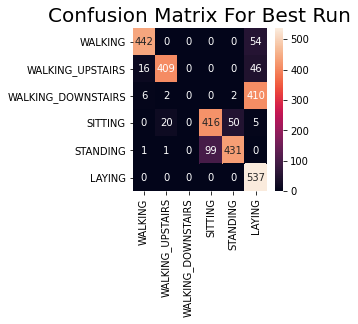

Starting experiment with batch_size=64
#1: 63.081
Accuracy over 1 trials: 63.081% (+/-0.000)


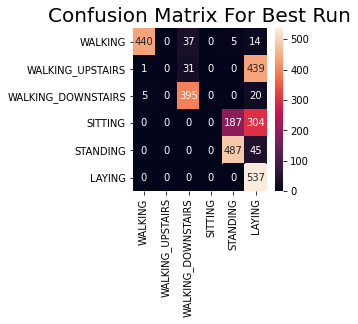

Starting experiment with batch_size=128
#1: 76.960
Accuracy over 1 trials: 76.960% (+/-0.000)


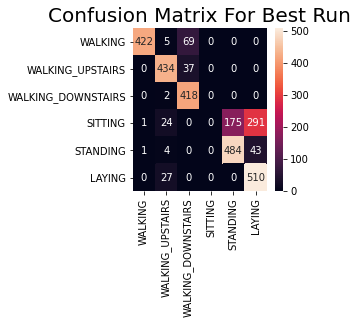

Starting experiment with batch_size=256
#1: 76.858
Accuracy over 1 trials: 76.858% (+/-0.000)


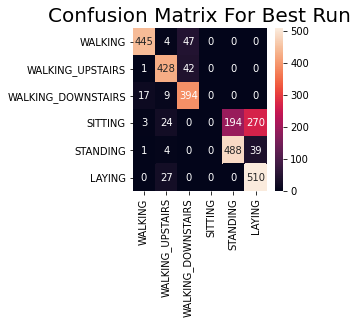

In [33]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = [8,16,32,64,128,256],
    repeat_on = "batch_size"
)
comparative_experiment = ComparativeExperiment(config)
comparative_experiment.run()

Batch size 128 seems to be the best.

# Conclusions

It has been a good weekend's worth of exciting work. Here's a few observations and recommendations in no particular order.

- I tried to keep the 1DConv model like for like from the article, but it has not been possible to consistently get 90%+ accuracy. I have not re-run the keras model from the article (as I didn't want to spend time fixing potential issues with version mismatches of keras and tf used in the article).


- Given the very minimal improvement in accuracy (in the article) after standardising the dataset, I did not try it myself. But it is definitely something I would try.


- One major thing I noticed in the article is that the way the experiments are conducted and compared is not adequate because the model (at least in PyTorch) is performing wildly differently based on the initial weights. I noticed that I sometimes get 90%+ on a run and a subsequent run drops down to 40%.


- In the article, all the experiments are run for 10 epochs per repeat. Perhaps the PyTorch equivalent needs more epochs to converge with an adaptive learning rate. Given the time, I have not experimented with longer than 50epochs.


- The article suggests a multi-headed CNN to improve the performance. I wanted to try something different, so I tried the LSTM model and was able to get consistent good performance with a simple model.


- I could try other flavours of the LSTM but given the training takes considerably longer, I did not experiment further.


- The experimentation framework seems like a good starting point and I'd improve it going forward.
